[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [5]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("roboflow_api")

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [6]:
!nvidia-smi

Sat Apr 26 20:59:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Q9lrgbTod37Gub7bqwui")
project = rf.workspace("labelling-24hrm").project("my-first-project-dar4n")
version = project.version(2)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...


In [8]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [5]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 69.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 116.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [ ]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-02-19 17:12:39--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-02-19 17:12:39 (95.4 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

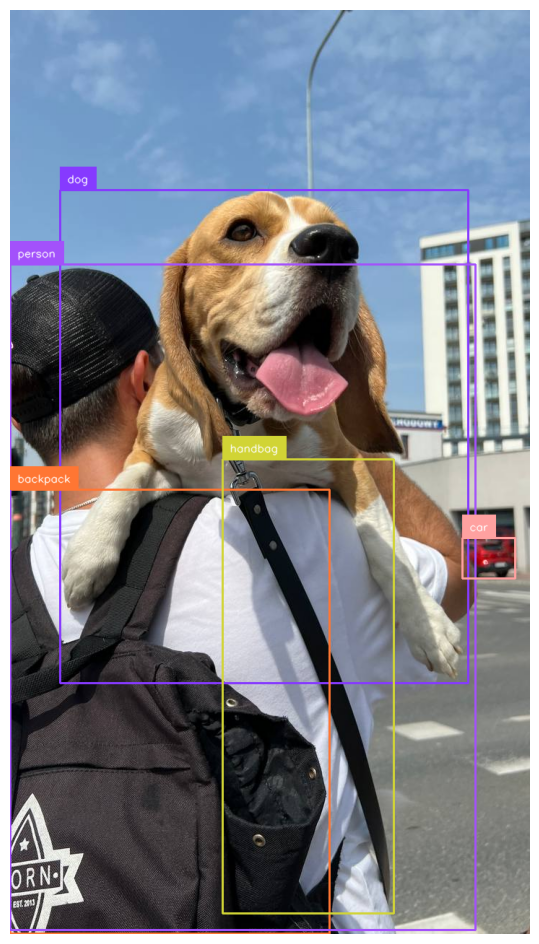

In [ ]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [6]:
from roboflow import download_dataset

dataset = download_dataset('https://universe.roboflow.com/labelling-24hrm/my-first-project-dar4n/dataset/2', 'yolov8')

loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov8 in progress : 85.0%
Version export complete for yolov8 format



Extracting Dataset Version Zip to My-First-Project-2 in yolov8:: 100%|██████████| 2924/2924 [00:04<00:00, 681.95it/s] 


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


In [9]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [10]:
!pip install opencv-python albumentations copy-paste-aug


ERROR: Could not find a version that satisfies the requirement copy-paste-aug (from versions: none)
ERROR: No matching distribution found for copy-paste-aug


In [14]:
!ls

My-First-Project-2  sample_data


In [16]:
!git clone https://github.com/conradry/copy-paste-aug.git


Cloning into 'copy-paste-aug'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 53 (delta 25), reused 31 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 1.20 MiB | 3.80 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [17]:
%cd copy-paste-aug


/content/copy-paste-aug


In [18]:
!pip install -e .

# Install dependencies
!pip install albumentations opencv-python

Obtaining file:///content/copy-paste-aug
ERROR: file:///content/copy-paste-aug does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [21]:
import os
import cv2
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from copy_paste import CopyPaste

# === Paths ===
root_dir = "/content/My-First-Project-2/train"  # change to train / valid / test accordingly
images_dir = os.path.join(root_dir, "images")
labels_dir = os.path.join(root_dir, "labels")

output_images_dir = os.path.join(root_dir, "augmented_images")
output_labels_dir = os.path.join(root_dir, "augmented_labels")

os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_labels_dir, exist_ok=True)

# === Helper functions ===
def load_yolo_label(label_path, img_width, img_height):
    boxes = []
    with open(label_path, "r") as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            cls = int(parts[0])
            cx, cy, w, h = map(float, parts[1:])

            x_min = (cx - w/2) * img_width
            y_min = (cy - h/2) * img_height
            width = w * img_width
            height = h * img_height

            # (x_min, y_min, width, height, class_id, mask_idx)
            boxes.append([x_min, y_min, width, height, cls, 0])
    return boxes

def create_dummy_masks(bboxes, img_shape):
    masks = []
    for bbox in bboxes:
        x_min, y_min, width, height, _, _ = bbox
        mask = np.zeros(img_shape[:2], dtype=np.uint8)
        x_min = int(x_min)
        y_min = int(y_min)
        x_max = int(x_min + width)
        y_max = int(y_min + height)
        cv2.rectangle(mask, (x_min, y_min), (x_max, y_max), color=1, thickness=-1)
        masks.append(mask)
    return masks

def coco_bbox_to_yolo(bbox, img_w, img_h):
    """Convert (x_min, y_min, width, height) to YOLO format"""
    x_min, y_min, width, height = bbox
    x_center = (x_min + width / 2) / img_w
    y_center = (y_min + height / 2) / img_h
    width /= img_w
    height /= img_h
    return x_center, y_center, width, height

# === Define Transforms ===
transform = A.Compose([
    A.RandomScale(scale_limit=(-0.5, 0.5), p=1),
    A.PadIfNeeded(512, 512, border_mode=0),
    A.RandomCrop(512, 512),
    A.HorizontalFlip(p=0.5),
    CopyPaste(blend=True, sigma=1, pct_objects_paste=0.5, p=1)
], bbox_params=A.BboxParams(format="coco", label_fields=[]))

# === Process all images ===
image_files = [f for f in os.listdir(images_dir) if f.endswith(".jpg") or f.endswith(".png")]

for img_file in image_files:
    img_path = os.path.join(images_dir, img_file)
    label_path = os.path.join(labels_dir, os.path.splitext(img_file)[0] + ".txt")

    image = cv2.imread(img_path)
    img_h, img_w = image.shape[:2]
    bboxes = load_yolo_label(label_path, img_w, img_h)
    masks = create_dummy_masks(bboxes, image.shape)

    # Pick a random other image for paste
    paste_img_file = random.choice(image_files)
    paste_img_path = os.path.join(images_dir, paste_img_file)
    paste_label_path = os.path.join(labels_dir, os.path.splitext(paste_img_file)[0] + ".txt")

    paste_image = cv2.imread(paste_img_path)
    paste_img_h, paste_img_w = paste_image.shape[:2]
    paste_bboxes = load_yolo_label(paste_label_path, paste_img_w, paste_img_h)
    paste_masks = create_dummy_masks(paste_bboxes, paste_image.shape)

    # Apply transform
    augmented = transform(
        image=image,
        masks=masks,
        bboxes=bboxes,
        paste_image=paste_image,
        paste_masks=paste_masks,
        paste_bboxes=paste_bboxes,
    )

    aug_img = augmented["image"]
    aug_masks = augmented["masks"]
    aug_bboxes = augmented["bboxes"]

    # Save new image
    new_img_name = f"copypaste_{img_file}"
    cv2.imwrite(os.path.join(output_images_dir, new_img_name), aug_img)

    # Save new label
    new_label_name = f"copypaste_{os.path.splitext(img_file)[0]}.txt"
    new_label_path = os.path.join(output_labels_dir, new_label_name)

    with open(new_label_path, 'w') as f:
        for bbox in aug_bboxes:
            x_center, y_center, width, height = coco_bbox_to_yolo(bbox[:4], aug_img.shape[1], aug_img.shape[0])
            class_id = int(bbox[4])
            f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

print("✅ Copy-Paste Augmentation Done!")


AttributeError: 'CopyPaste' object has no attribute 'update_params'

In [8]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [9]:
!cat {dataset.location}/data.yaml

names:
- car
- pedestrian
- traffic light
- traffic light-green
- traffic light-red
- traffic light-red_left
- traffic light-yellow
- truck
nc: 8
roboflow:
  license: CC BY 4.0
  project: my-first-project-dar4n
  url: https://universe.roboflow.com/labelling-24hrm/my-first-project-dar4n/dataset/2
  version: 2
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [11]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=10)

New https://pypi.org/project/ultralytics/8.3.116 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/My-First-Project-2/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=Fal

train: Scanning /content/My-First-Project-2/train/labels.cache... 1019 images, 10 backgrounds, 0 corrupt: 100%|██████████| 1019/1019 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/My-First-Project-2/valid/labels.cache... 293 images, 2 backgrounds, 0 corrupt: 100%|██████████| 293/293 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      12.2G      4.182      7.942      4.229         55        640: 100%|██████████| 64/64 [00:40<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


                   all        293       1332   9.95e-06   0.000166   8.16e-06   2.45e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      12.2G      3.554       4.98      3.152         68        640: 100%|██████████| 64/64 [00:37<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]

                   all        293       1332   1.28e-05   0.000166   6.92e-06   2.08e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      12.4G      2.958      3.446      2.444         45        640: 100%|██████████| 64/64 [00:36<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]

                   all        293       1332      0.907     0.0431      0.043     0.0146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      12.2G      2.557      2.573      2.048         47        640: 100%|██████████| 64/64 [00:36<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]

                   all        293       1332      0.471     0.0914     0.0893     0.0372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      12.2G      2.284      2.148      1.869         42        640: 100%|██████████| 64/64 [00:36<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]

                   all        293       1332       0.62      0.108      0.124     0.0594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      12.4G      2.135      1.933      1.761         39        640: 100%|██████████| 64/64 [00:36<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.50it/s]

                   all        293       1332      0.361      0.167      0.149     0.0696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      12.2G      1.964      1.775      1.675         53        640: 100%|██████████| 64/64 [00:35<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


                   all        293       1332      0.606      0.175      0.182     0.0994

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      12.4G      1.875      1.681      1.614         52        640: 100%|██████████| 64/64 [00:36<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


                   all        293       1332      0.428      0.186      0.197       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      12.4G      1.851       1.63      1.568         41        640: 100%|██████████| 64/64 [00:36<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


                   all        293       1332      0.528      0.178      0.195      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      12.4G      1.795      1.578      1.547         44        640: 100%|██████████| 64/64 [00:36<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


                   all        293       1332      0.202      0.205      0.199      0.118

10 epochs completed in 0.122 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 18.6MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,077,304 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


                   all        293       1332        0.2      0.204      0.199      0.118
                   car        285        861      0.416      0.764       0.67      0.388
            pedestrian         50         84      0.486      0.143      0.138     0.0443
         traffic light         48         79     0.0934     0.0633     0.0902     0.0409
   traffic light-green         19         19          0          0      0.011    0.00387
     traffic light-red        108        247      0.407      0.457      0.435      0.332
  traffic light-yellow          3          4          0          0    0.00374    0.00112
                 truck         38         38          0          0     0.0454     0.0164
Speed: 0.3ms preprocess, 6.5ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/detect/train2


## Evaluate fine-tuned YOLOv12 model

In [12]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					   train_batch0.jpg
events.out.tfevents.1745581803.3b068bd97a52.262.0  train_batch1.jpg
labels_correlogram.jpg				   train_batch2.jpg
labels.jpg					   weights
results.csv


In [16]:
import pandas as pd

# Path to your results.csv
csv_path = f'{HOME}/runs/detect/train2/results.csv'

# Load the CSV
df = pd.read_csv(csv_path)

# Show the last row (best epoch)
last_epoch = df.iloc[-1]

# If you want to see all columns to explore:
print(df.columns.tolist())

# Print class-wise precision and recall (if available)
# Typically YOLO reports mean precision, recall, and mAP in this file
print("Precision (mean):", last_epoch['metrics/precision(B)'])
print("Recall (mean):", last_epoch['metrics/recall(B)'])

# If class-wise precision/recall is not included in the CSV,
# we'll need to compute them manually using predictions and ground truths.


['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']
Precision (mean): 0.20155
Recall (mean): 0.20463


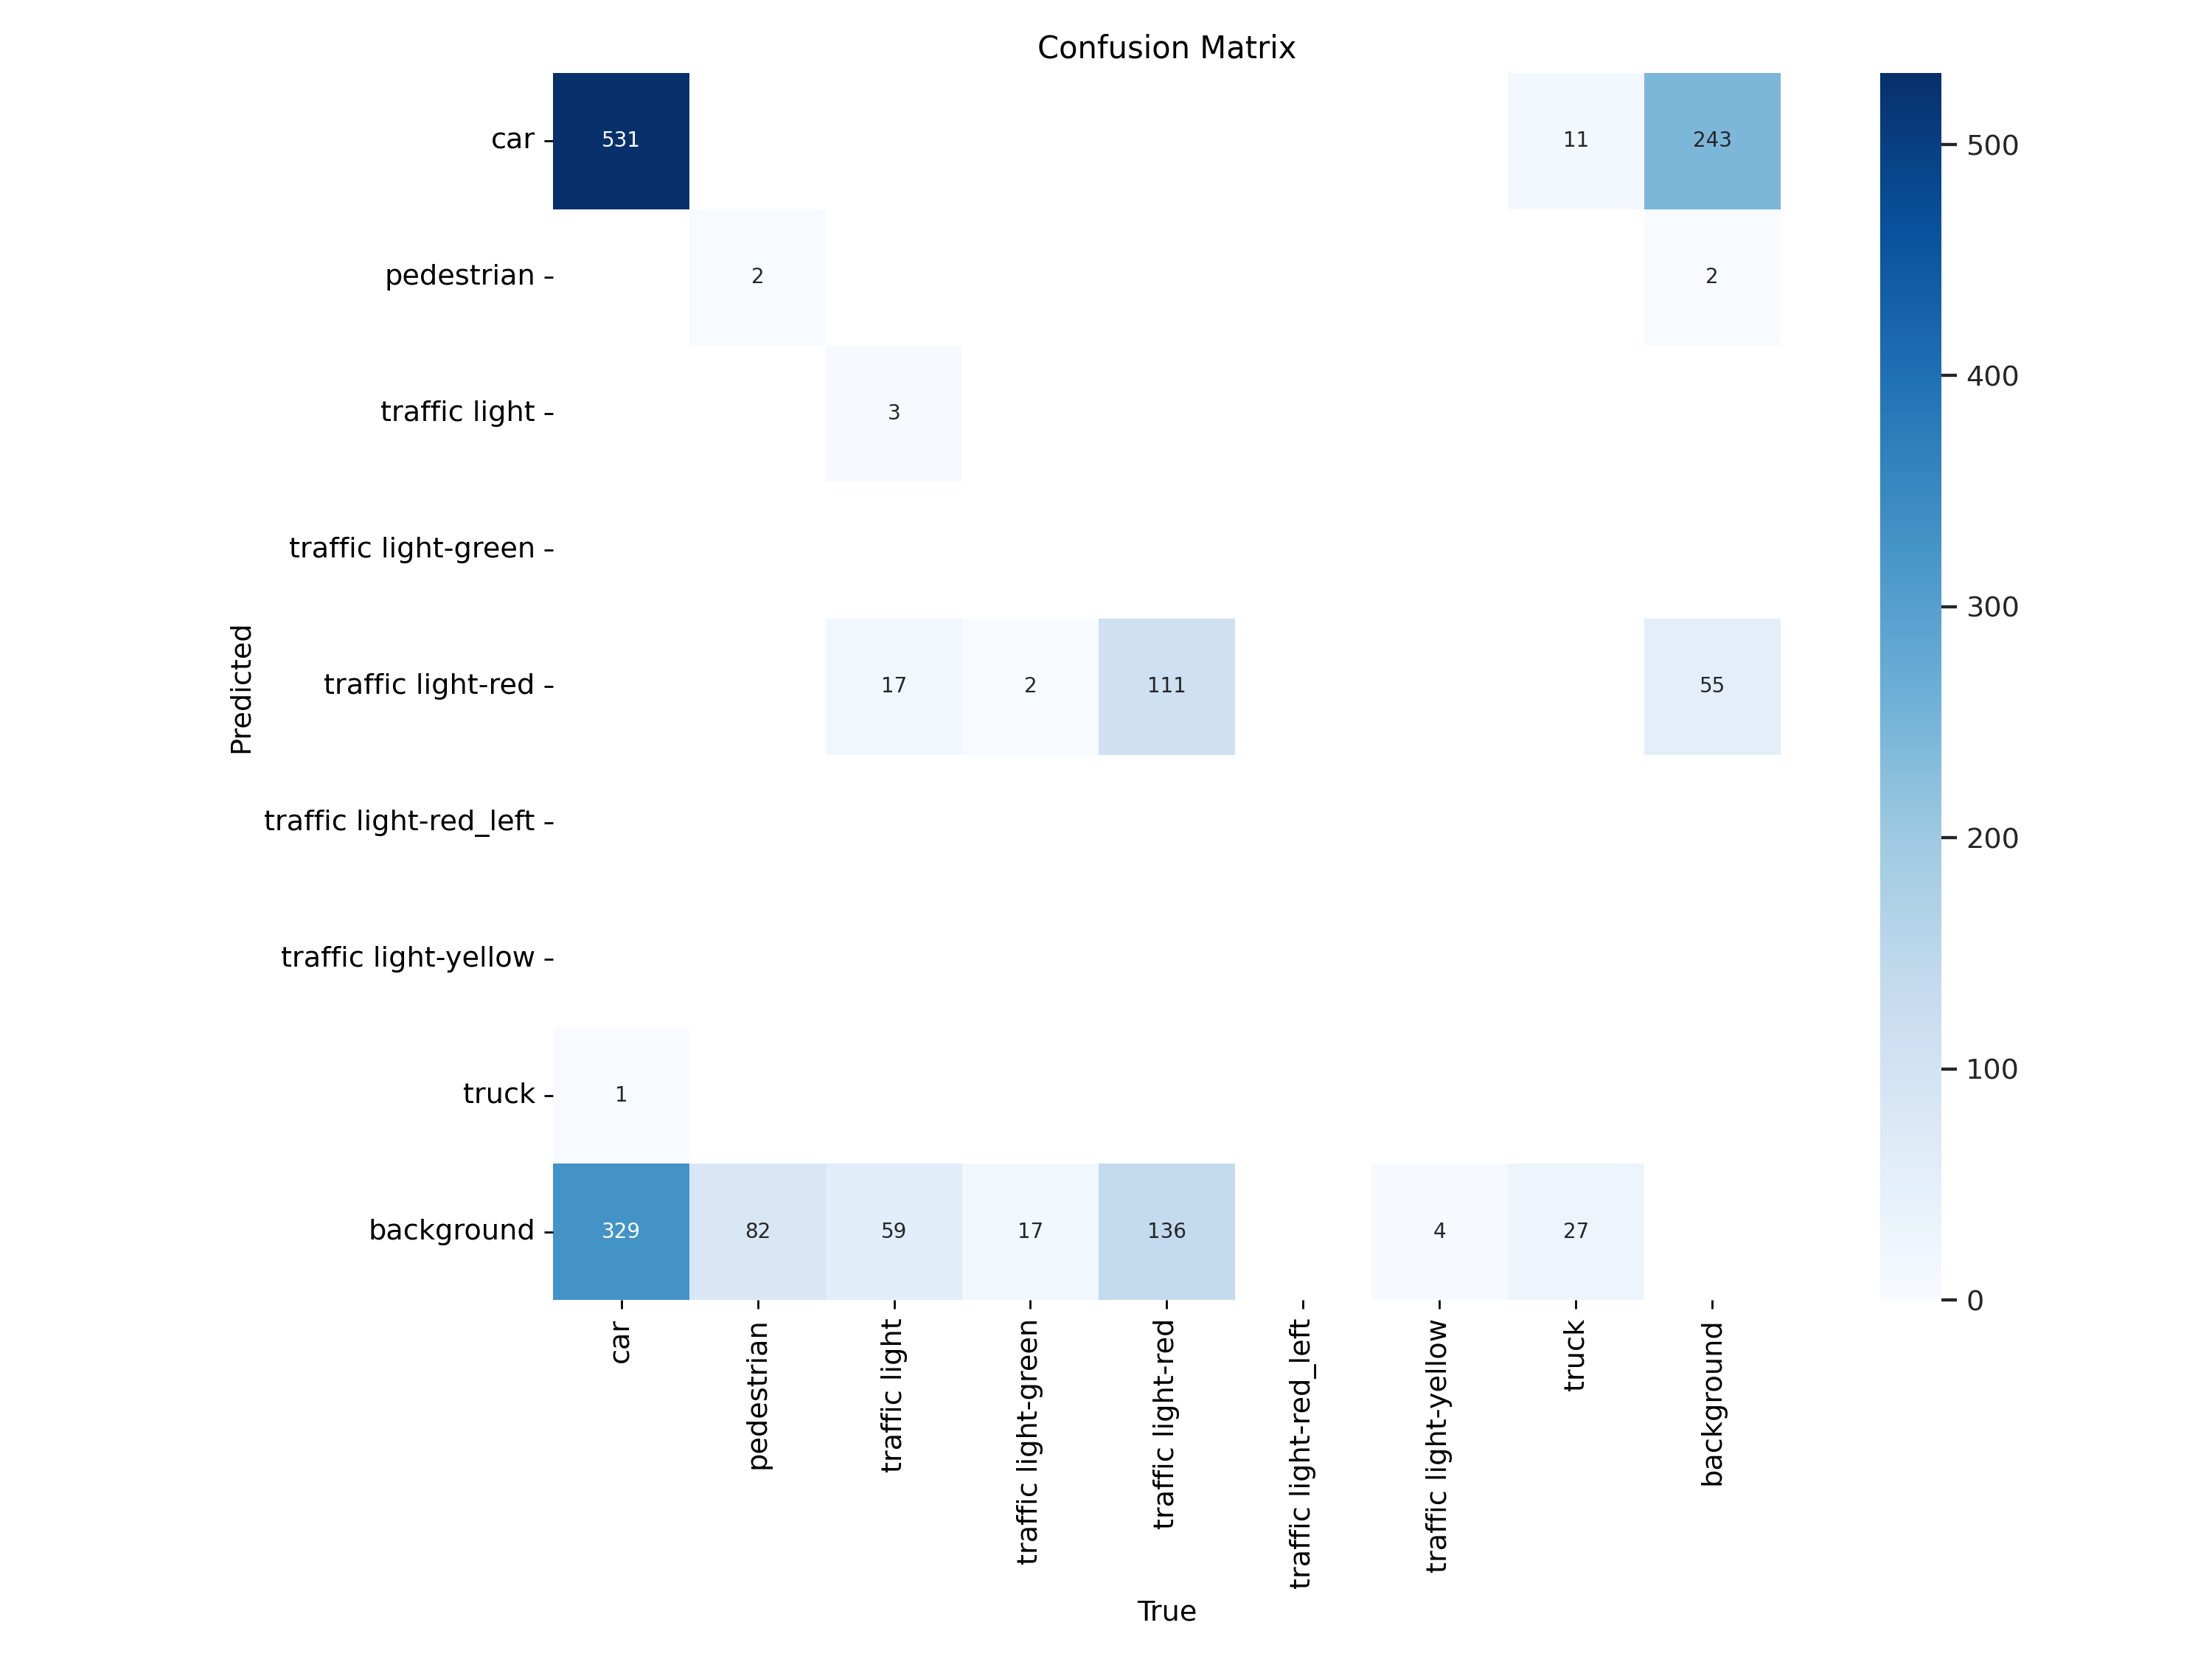

In [14]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train2/confusion_matrix.png', width=1000)

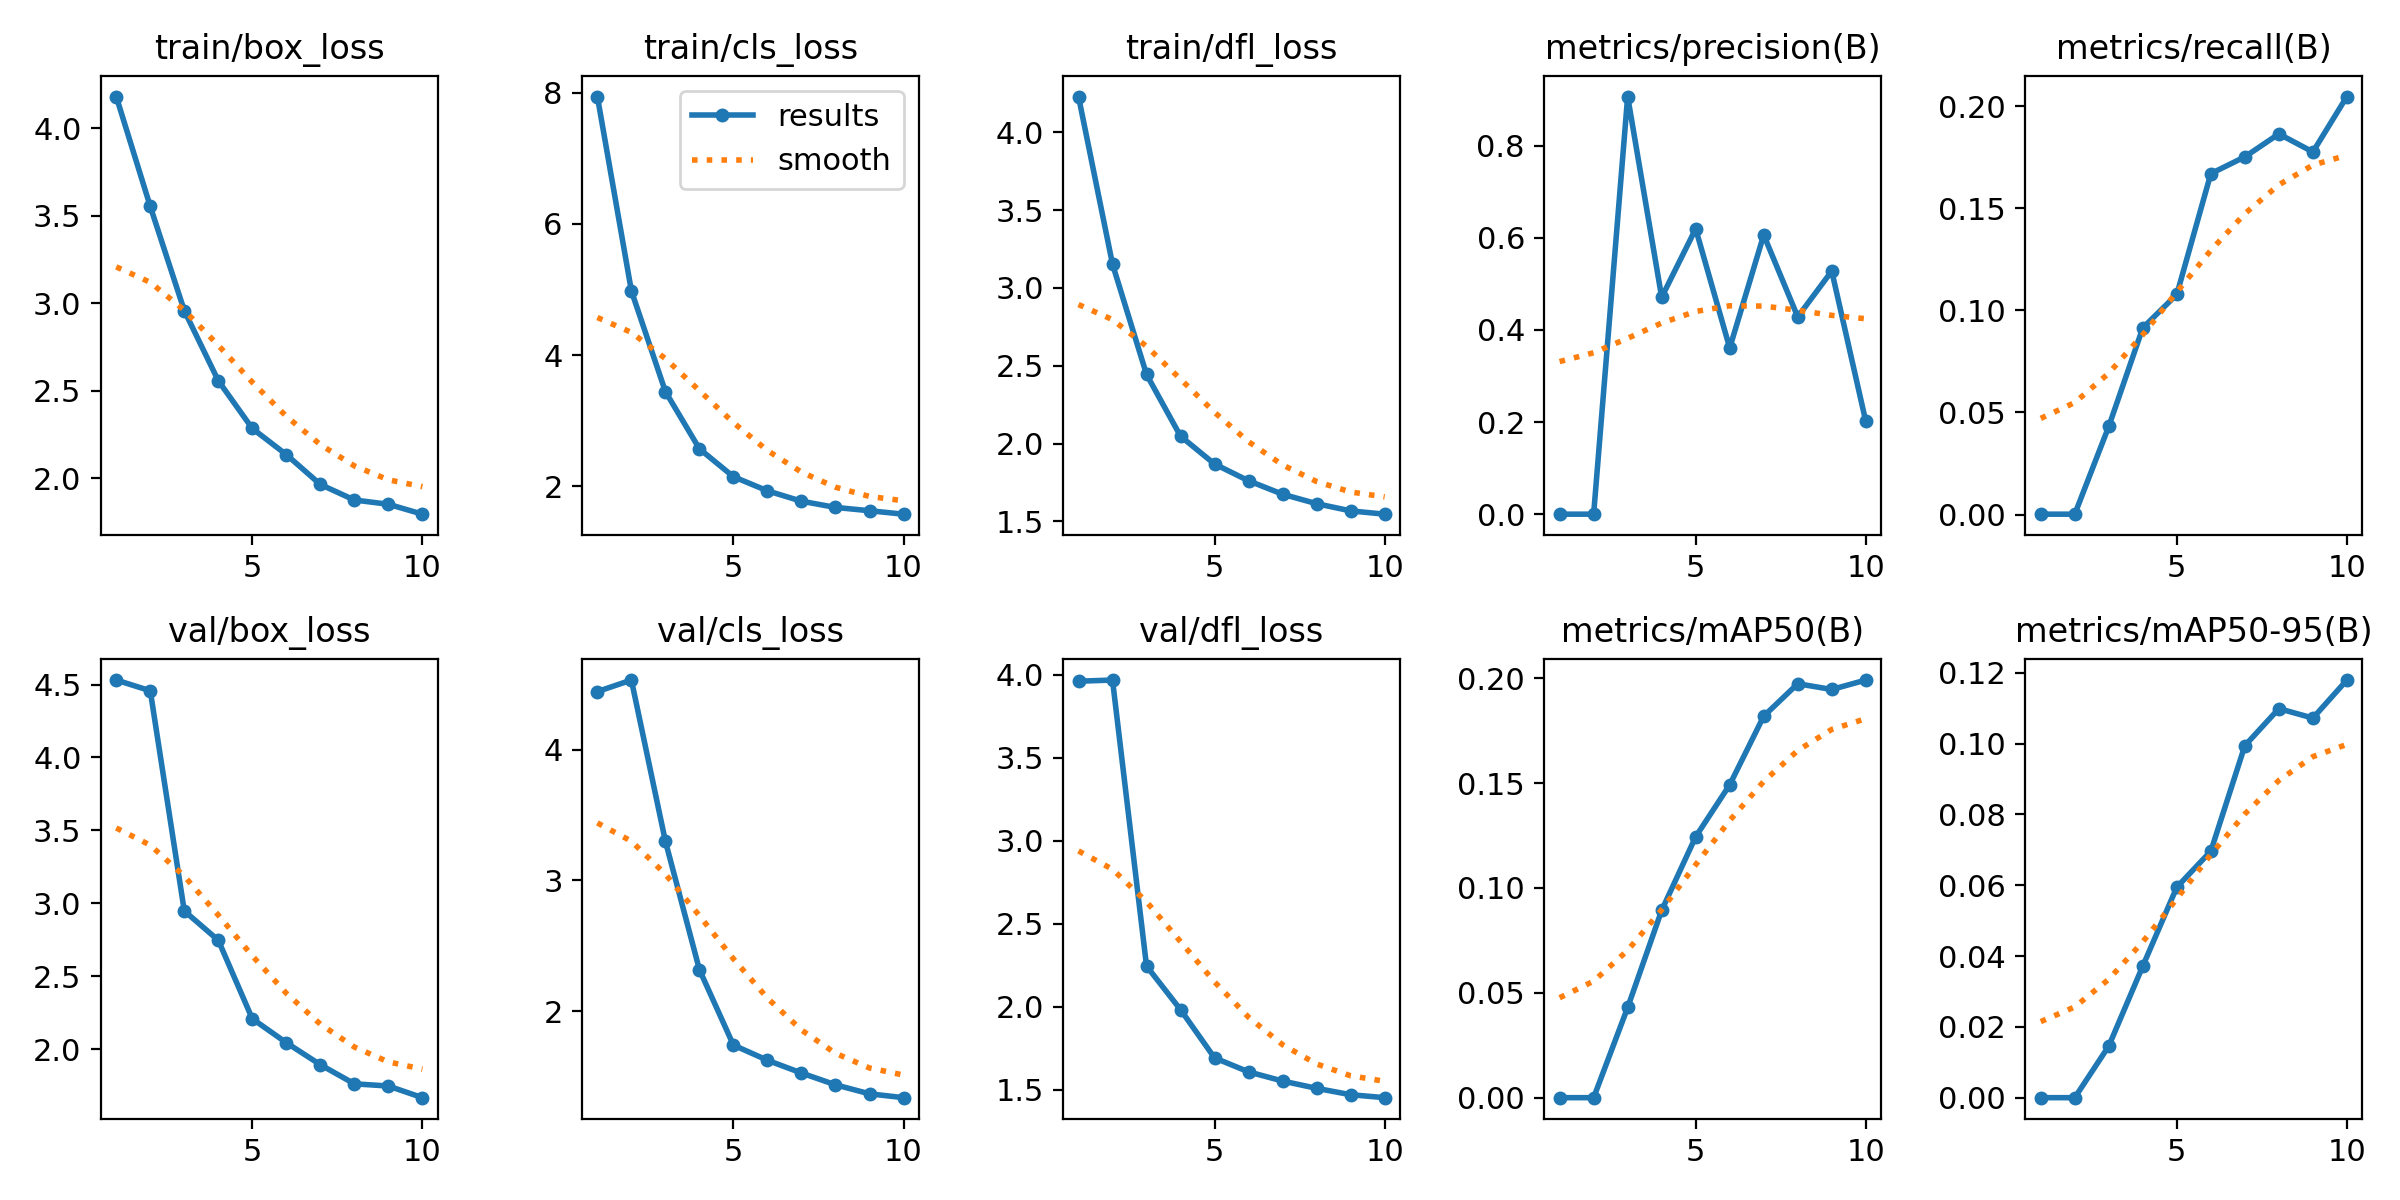

In [17]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train2/results.png', width=1000)

In [18]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['car',
 'pedestrian',
 'traffic light',
 'traffic light-green',
 'traffic light-red',
 'traffic light-red_left',
 'traffic light-yellow',
 'truck']

In [19]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train2/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [20]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.08240387388270048
mAP 50 0.14469898015191532
mAP 75 0.07845605184841664


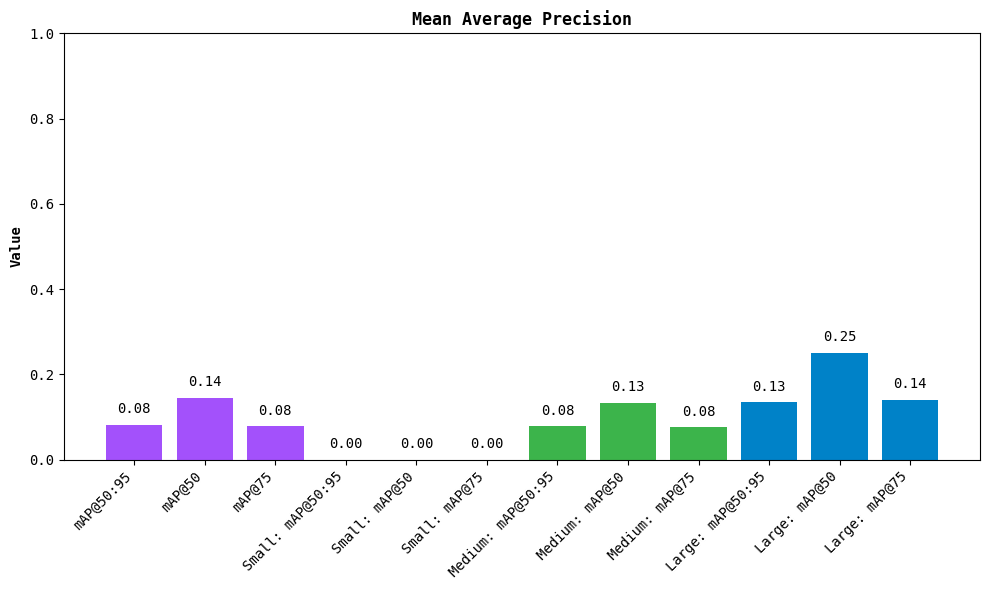

In [21]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [22]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train2/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

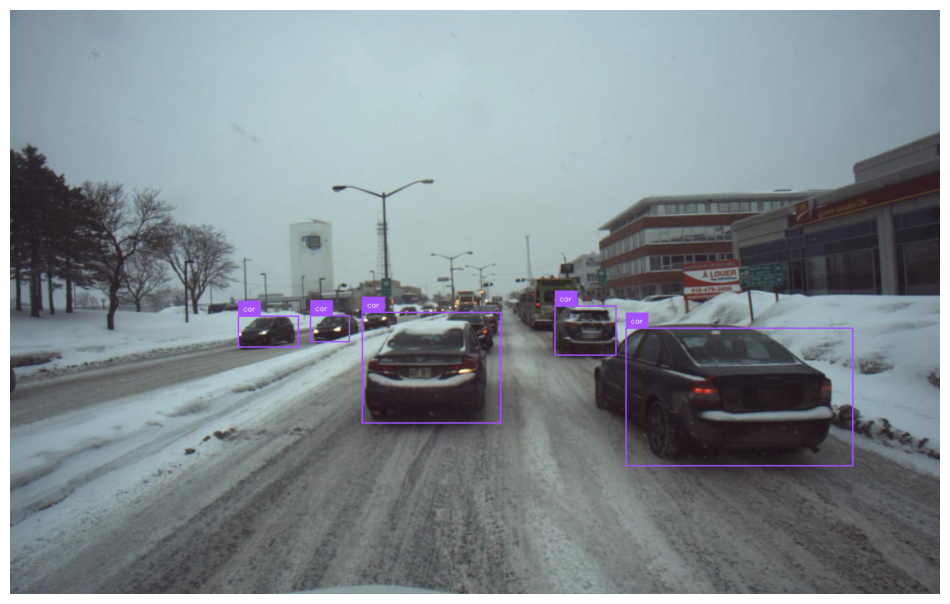

In [23]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)